# Load data


In [3]:
from function import *
import pandas as pd
import pandas as pd
import geopandas as gpd
from typing import Sequence



abandon_2d_variable = [
    "current_abandonment",
    "recultivation", 
    "abandonment_duration",
    "abandonment_year"
]
fea_3d_variable = [
    'GDPpc',
    'GDPtot',   
    'GURdist',
    'Population',
    'gdmp',
    'rsds',
    'tas',
    'wind'
]
fea_2d_variable = [
    'DEM',
    'Powerdist',
    'PrimaryRoad',
    'SecondaryRoad',
    'Slope',
    'TertiaryRoad'
]
PATHS = {
    'abandonment': r"D:\xarray\merged_chunk_2\*.nc",
    'feature':     "D:/xarray/aligned2/Feature_all/*.nc",
    'csv':         "aligned_for_training0519.csv",
    'prediction':  "",
    'prediction_us': r"data\abandon_filtered_with_scores.csv",
    'test_output': "positive_samples_test_500.csv",
    'output':      "positive_samples_full_with_features.csv",
    'CN_sheng': r'data\sheng2022.shp',
    'World_shp': r'data\main_ADM_0.shp', 
    'us_abandon': r'data\us_abandon_clean.csv',
    'us_pv_embedding': r'data\training_embedding.csv'
}

ZERO_COLS = [
     'GDPpc', 'GDPtot', 'GURdist', 'Population',
    'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'gdmp'
]
YEARS = [2018, 2020]

NUMERIC_FEATURES = [
    'lat','lon','GDPpc', 'GDPtot', 'GURdist', 'DEM','Slope',
    'Population','Powerdist','PrimaryRoad','SecondaryRoad','TertiaryRoad',
    'gdmp','rsds','tas','wind'
]
CAT_COLS = ['landcover']

ABANDON_COLS = ['abandonment_year','abandonment_duration', 'current_abandonment']

NONE_ABANDON_COLS = ['recultivation']

time=['2018-01-01','2020-01-01']


from function import *  
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import json
from datetime import datetime
import platform

def normalize_path(path):
    """
    跨平台路径规范化
    将Windows路径中的反斜杠转换为正斜杠（在Linux/WSL中）
    Windows: r'data\file.shp' -> r'data\file.shp' (保持不变)
    Linux/WSL: r'data\file.shp' -> 'data/file.shp' (转换)
    """
    if isinstance(path, str):
        # 检测是否在WSL或Linux环境中
        is_linux = platform.system() in ['Linux', 'Darwin']
        
        if is_linux:
            # 在Linux/WSL中，将反斜杠转为正斜杠
            path = path.replace('\\', '/')
        
        return path
    return path

def normalize_paths_dict(paths_dict):
    """
    规范化路径字典中的所有路径
    """
    normalized = {}
    for key, value in paths_dict.items():
        normalized[key] = normalize_path(value)
    return normalized

PATHS = normalize_paths_dict(PATHS)

def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped




# 0) 基础地理范围与底图
usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
us_states = gpd.read_file('data/cb_2018_us_state_500k.shp')

# ---------------------------
# 1) 读取数据
# ---------------------------
df_abandon = load_abandon(PATHS['us_abandon'])
df_embedding = load_embedding(PATHS['us_pv_embedding'])

# 初步经纬度范围过滤
df_embedding = df_embedding[
    (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
    (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
    (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
    (df_embedding['lat'] <= usa_bounds_main['lat_max'])
]

# 第二次用州界矢量更精确裁剪
df_abandon = clip_data_with_us_states(df_abandon, us_states)
df_embedding = clip_data_with_us_states(df_embedding, us_states)

# ---------------------------
# 2) 缺失值填充 + 去重
# ---------------------------
df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

us_df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)

# 导入特征数据集
# us_df_abandon_filtered = pd.read_csv(PATHS['us_abandon'])
ds_abandon, ds_feat = load_datasets(PATHS['abandonment'], PATHS['feature'])
ds_merge=xr.merge([ds_abandon, ds_feat])



You want to predict the year: 2020.0
列 GDPpc 没有需要填充的非正值或NaN值
列 GDPtot 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
列 Population 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值
列 GDPtot 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
列 Population 没有需要填充的非正值或NaN值


c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 174
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(
c:\Users\zpy10\anacon

# 碳排放净减少效益测算

Given the'us_df_abandon_filtered' dataframe. 

| T_cell | 气温、辐射、风速 | a1+a2×Temperature+a3×Radiation+a4×Wind，其中a1=4.3℃，a2=0.0943（常数），a3=0.028℃/（辐射单位），a4=-1.528℃/（风速单位） | 这里将原文献仅用辐照数据的参数进一步改进 |
| ------ | -------- | ------------------------------------------------------------------------------------------------- | -------------------- |



输入数据：

将PV减排因子等价成对应能源系统的二氧化碳排放因子。

$$EF_{pv,mitigation}=E_{grid,CM}=EF_{grid,OM}W_{OM}+EF_{grid,BM}W_{BM}$$

一般来说，已经给出了各个国家的CM边际排放因子，可以直接沿用即可

us:352 gCO2/kWh


In [2]:
us_df_abandon_filtered

,Unnamed: 0,time,lat,lon,abandonment_year,abandonment_duration,current_abandonment,landcover,DEM,GDPpc,...,Powerdist,PrimaryRoad,SecondaryRoad,Slope,TertiaryRoad,gdmp,rsds,tas,wind,env_scores
0,2094,2020-01-01,25.004168,-107.545830,2018.0,6.0,1,2.0,128.7500,22847.0,...,622572.70,9.479545,2.584110,0.922605,44.558012,65.551445,20.555853,2981.984506,1.413225,0.305240
1,4586,2020-01-01,25.012500,-107.612500,2017.0,7.0,1,2.0,96.3125,11575.0,...,622572.60,7.480710,2.584110,4.124147,77.081042,76.545799,20.408821,2982.749690,1.381223,0.264706
2,4601,2020-01-01,25.012500,-107.487500,2017.0,7.0,1,2.0,176.3750,22847.0,...,622572.70,9.479545,2.584110,2.743563,51.958872,80.134598,20.785990,2980.215050,1.337188,0.293005
3,9586,2020-01-01,25.029167,-107.612500,2017.0,7.0,1,2.0,77.1250,11575.0,...,622572.60,7.480710,2.584110,1.319031,77.081042,62.175598,20.607885,2983.972465,1.395731,0.182346
4,9850,2020-01-01,25.029167,-105.412500,2017.0,7.0,1,2.0,1730.6250,10594.0,...,622573.30,7.372286,15.512376,1.524049,217.405949,104.869400,22.585236,2913.419221,1.931024,0.223332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70307,20522499,2020-01-01,48.187500,-65.837500,1998.0,26.0,1,3.0,46.5000,29640.0,...,622564.00,15.564339,0.007833,2.177264,91.230789,70.525002,12.947352,2763.749943,3.296368,0.307058
70308,20625641,2020-01-01,48.579166,-67.987500,1998.0,26.0,1,2.0,228.4375,33888.0,...,622562.94,54.122274,0.299834,1.650701,43.559419,58.398994,13.006569,2756.330329,4.223490,0.309734
70309,20669107,2020-01-01,48.745834,-72.437500,2012.0,12.0,1,2.0,105.2500,42697.0,...,622561.40,16.693830,1.095873,0.152130,40.225892,91.527328,12.529724,2756.581936,3.581519,0.306415
70310,20673507,2020-01-01,48.762500,-72.437500,2009.0,15.0,1,2.0,106.8125,43202.0,...,622561.40,8.394693,1.095873,0.207614,28.790137,79.406998,12.526788,2756.086073,3.699206,0.309188


In [4]:
us_df_abandon_filtered

,lat,lon,time,abandonment_year,abandonment_duration,current_abandonment,landcover,DEM,gdmp,GDPpc,...,landcover_at_abandonment,Population,Powerdist,PrimaryRoad,rsds,SecondaryRoad,Slope,tas,TertiaryRoad,wind
0,21.895834,-159.47084,2020-01-01,2013.0,10.0,1,2.0,51.2500,117.119888,41938.0,...,NaN,402.430940,3.292825e+06,0.000000,20.518538,0.000000,2.791620,2975.645809,0.000000,4.574830
1,21.904167,-159.57916,2020-01-01,2014.0,9.0,1,2.0,32.7500,37.481422,41938.0,...,NaN,484.819730,3.291227e+06,0.000000,20.408428,0.000000,2.495157,2978.889888,0.000000,4.228809
2,21.904167,-159.52083,2020-01-01,2011.0,12.0,1,2.0,138.5000,160.905777,41938.0,...,NaN,569.599550,3.291664e+06,0.000000,20.648110,0.000000,4.957572,2971.540692,0.000000,4.864865
3,21.904167,-159.46250,2020-01-01,2010.0,13.0,1,4.0,67.6875,144.940460,41938.0,...,NaN,1405.485100,3.292111e+06,0.000000,20.446064,0.000000,0.546027,2974.577779,0.000000,4.176537
4,21.912500,-159.52083,2020-01-01,2010.0,13.0,1,2.0,204.3750,173.481995,41938.0,...,NaN,590.756800,3.290108e+06,0.000000,20.524061,0.000000,4.916435,2967.891430,0.000000,4.685113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71765,63.912500,-145.21250,2020-01-01,2009.0,14.0,1,2.0,359.8125,64.978180,51983.0,...,NaN,1.104929,7.807899e+02,5.781066,9.471990,0.000000,0.177922,2740.998586,37.049534,4.148036
71766,64.012500,-145.00417,2020-01-01,2010.0,13.0,1,2.0,335.2500,64.978180,51983.0,...,NaN,0.243558,9.369479e+03,0.000000,9.336362,0.000000,0.102241,2739.998586,14.365114,3.614530
71767,64.029170,-145.11250,2020-01-01,2018.0,5.0,1,2.0,331.8750,64.978180,51983.0,...,NaN,0.197275,9.369479e+03,0.000000,9.334987,0.000000,0.085302,2740.333333,14.133357,3.510094
71768,64.129166,-145.66250,2020-01-01,1998.0,25.0,1,2.0,317.8125,64.978180,51983.0,...,NaN,24.505394,7.807899e+02,0.000000,9.329527,3.136633,0.279026,2741.830566,70.305156,3.456614


# 1、方法A：光伏发电粗糙版思路

In [5]:
import pandas as pd
import numpy as np

def compute_pv_potential_fixed(
    df: pd.DataFrame,
    rsds_col: str = 'rsds',
    tas_col: str = 'tas',
    wind_col: str = 'wind',
    lat_col: str = 'lat',
    lom_col: str = 'lon',
    eta_stc: float = 0.17,
    eta_sys: float = 0.8,
    pixel_size_deg: float = 0.0083333
) -> pd.DataFrame:
    """
    修正后的思路A：假设 df['rsds'] 已经是 “物理上的 MJ/m²/d”。
    -------------------------------------------------------------
    1) I (W/m²) = df['rsds'] (MJ/m²/d) * 1e6 (J/MJ) / 86400 (s/d)
    2) T_amb_C (℃) = df['tas']*0.1 (从 K/10 到 K) - 273.15
    3) T_cell (℃) = 4.3 + 0.943*T_amb_C + 0.028*I - 1.528*wind
    4) PR = 1 + γ*(T_cell - 25), γ = -0.005 1/℃
    5) PVPOT = PR * I / 1000
    6) area_m2 = pixel 面积
    7) E_yr_per_m2 = η_stc * PVPOT * η_sys * 8760   (kWh/m²/yr)
    8) E_yr_pixel = E_yr_per_m2 * area_m2
    """
    df = df.copy()

    # ——（1）rsds: MJ/m²/d -> I: W/m² —— 
    # 直接用物理上已经是 MJ/m²/d 的数值（无需再乘 0.001）
    df['I'] = df[rsds_col] * 1e6 / 86400.0  # W/m²

    # ——（2）T_amb_C: tas (K/10) -> ℃ ——
    # 如果 NetCDF 原始里 tas 存成 K/10，需要先乘以 0.1
    df['T_amb_C'] = df[tas_col] * 0.1 - 273.15

    # ——（3）T_cell: 经验式 —— 
    df['T_cell'] = (
        4.3
        + 0.943 * df['T_amb_C']
        + 0.028 * df['I']
        - 1.528 * df['wind']
    )

    # ——（4）PR: 性能比 —— 
    gamma = -0.005
    df['PR'] = 1 + gamma * (df['T_cell'] - 25.0)

    # ——（5）PVPOT —— 
    df['PVPOT'] = df['PR'] * df['I'] / 1000.0

    # ——（6）像素面积 area_m2 —— 
    # 地球平均半径 ~ 6 371 000 m
    R = 6371000.0
    deg2rad = np.pi / 180.0
    dlat = pixel_size_deg * deg2rad
    dlon = pixel_size_deg * deg2rad
    lat_rad = df[lat_col] * deg2rad
    df['area_m2'] = (R * dlat) * (R * dlon * np.cos(lat_rad))

    # ——（7）单位面积年发电量 E_yr_per_m2 (kWh/m²/yr) —— 
    df['E_yr_per_m2'] = eta_stc * df['PVPOT'] * eta_sys * 8760.0

    # ——（8）像素总年发电量 E_yr_pixel (kWh/yr) —— 
    df['E_yr_pixel'] = df['E_yr_per_m2'] * df['area_m2']

    return df

# 用法示例（假设 df 已加载并含“rsds($\mathrm{MJ/m^2/d}$)”，“tas($\mathrm{K/10}$)”，“wind($\mathrm{m/s}$)”，“lat”，“lon”)：
fixed_df = compute_pv_potential_fixed(us_df_abandon_filtered)
# Calculate carbon emissions
fixed_df['carbon_emission (t)/yr'] = fixed_df['E_yr_pixel'] * 352 / 1000 / 1000


In [7]:
#fixed_df.to_csv('data/4.1_us_fixed.csv', index=False)
fixed_df.to_csv('data/4.data_prediction_net_benefit.csv', index=False)


# 3. Opportunity Loss


## 3.1 Step: Landchange Mask Map

Given ds_merge

it have time(year), lat, lon as coordinates and dimension.

It has varibles:
landcover, abandonment_year, etc.

For landcover, its float32, have the following values:

| New Class | Description |
|-----------|-------------|
| 1 | Cropland |
| 2 | Forest |
| 3 | Savanna |
| 4 | Shrub |
| 5 | Grassland and Arid Ecosystem |
| 6 | Wetland |
| 7 | Built-up |
| 8 | Bare Area and Ice |
| 9 | Water |

We want to get a new dataset, with same lat and lon, but without time dimension.


According to abandonment_year for each pixel, we want to get the landcover value for the year of abandonment.
For example, if abandonment_year is 2018, we want to get the landcover value for 2018.
and assign the landcover value to the corresponding pixel of new dataset.


In







Load Data

In [1]:
from function import *
import xarray as xr
ds_merge=load_all_ds()

ds_merge

gogogo


c:\Users\zpy10\Anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\Anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\Anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\Anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\Anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 174
  result = blockwise(
c:\Users\zpy10\Anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(
c:\Users\zpy10\Anacon

<xarray.Dataset> Size: 3TB
Dimensions:                   (time: 31, lat: 21600, lon: 43200)
Coordinates:
  * time                      (time) datetime64[ns] 248B 1992-01-01 ... 2022-...
    spatial_ref               int32 4B 0
    band                      int32 4B 1
  * lon                       (lon) float32 173kB -180.0 -180.0 ... 180.0 180.0
  * lat                       (lat) float32 86kB -90.0 -89.99 ... 89.99 90.0
Data variables: (12/20)
    abandonment_year          (time, lat, lon) float32 116GB dask.array<chunksize=(31, 500, 496), meta=np.ndarray>
    abandonment_duration      (time, lat, lon) float32 116GB dask.array<chunksize=(31, 500, 496), meta=np.ndarray>
    recultivation             (time, lat, lon) float32 116GB dask.array<chunksize=(31, 500, 496), meta=np.ndarray>
    current_abandonment       (time, lat, lon) float32 116GB dask.array<chunksize=(31, 500, 496), meta=np.ndarray>
    landcover                 (time, lat, lon) float32 116GB dask.array<chunksize=(16, 250, 249), meta=np.ndarray>
    DEM                       (time, lat, lon) float32 116GB dask.array<chunksize=(31, 1440, 2880), meta=np.ndarray>
    ...                        ...
    rsds                      (time, lat, lon) float32 116GB dask.array<chunksize=(1, 3085, 6172), meta=np.ndarray>
    SecondaryRoad             (time, lat, lon) float64 231GB dask.array<chunksize=(31, 981, 1964), meta=np.ndarray>
    Slope                     (time, lat, lon) float32 116GB dask.array<chunksize=(31, 1440, 2880), meta=np.ndarray>
    tas                       (time, lat, lon) float64 231GB dask.array<chunksize=(1, 2700, 5400), meta=np.ndarray>
    TertiaryRoad              (time, lat, lon) float64 231GB dask.array<chunksize=(31, 981, 1964), meta=np.ndarray>
    wind                      (time, lat, lon) float32 116GB dask.array<chunksize=(1, 432, 500), meta=np.ndarray>

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import os
from tqdm.auto import tqdm



def get_landcover_at_abandonment(ds):
    # 创建一个与landcover相同形状的结果数组
    result = xr.full_like(ds.landcover.isel(time=0), np.nan)
    
    # 对每个时间点进行处理
    for t in ds.time:
        # 获取当前时间点
        current_time = t.values
        current_year = pd.Timestamp(current_time).year
        
        # 找到abandonment_year等于当前年份的像素
        year_mask = (ds.abandonment_year.sel(time=current_time) == current_year)
        
        # 提取这些像素对应的landcover值
        landcover_values = ds.landcover.sel(time=current_time).where(year_mask)
        
        # 更新结果，只在之前为nan的位置更新
        result = xr.where(np.isnan(result) & ~np.isnan(landcover_values), 
                         landcover_values, 
                         result)
    
    return result

# 应用函数获取结果
landcover_at_abandonment = get_landcover_at_abandonment(ds_merge)

# 创建新的数据集
ds_new = xr.Dataset({
    'landcover_at_abandonment': landcover_at_abandonment
})



In [ ]:
import netCDF4
import os
import gc
import psutil
from datetime import datetime
from numba import njit, prange, float32, int64
import numpy as np
import xarray as xr

@njit(float32[:,:](float32[:,:], float32[:,:,:], int64[:]), parallel=True)
def process_chunk_numba(abdt_years, landcover_vals, time_years):
    """
    计算每个像素在弃耕年份的耕地状态或众数
    """
    nlat, nlon = abdt_years.shape
    tlen = time_years.shape[0]
    out = np.full((nlat, nlon), np.nan, dtype=np.float32)

    uniq_vals = np.empty(tlen, dtype=np.float32)
    uniq_counts = np.zeros(tlen, dtype=np.int32)

    for i in prange(nlat):
        for j in prange(nlon):
            ay = abdt_years[i, j]
            if np.isnan(ay):
                continue
            idx = -1
            for t in range(tlen):
                if time_years[t] == ay:
                    idx = t
                    break
            if idx < 0:
                continue

            # 连续两年耕地检测
            consec = False
            for t in range(idx, tlen - 1):
                if landcover_vals[t, i, j] == 1 and landcover_vals[t+1, i, j] == 1:
                    out[i, j] = 1.0
                    consec = True
                    break
            if consec:
                continue

            # 弃耕后年份众数计算
            n_unique = 0
            max_count = 0
            mode_val = np.float32(np.nan)
            for t in range(idx, tlen):
                v = landcover_vals[t, i, j]
                if np.isnan(v):
                    continue
                found = False
                for k in range(n_unique):
                    if uniq_vals[k] == v:
                        uniq_counts[k] += 1
                        if uniq_counts[k] > max_count:
                            max_count = uniq_counts[k]
                            mode_val = v
                        found = True
                        break
                if not found:
                    uniq_vals[n_unique] = v
                    uniq_counts[n_unique] = 1
                    if 1 > max_count:
                        max_count = 1
                        mode_val = v
                    n_unique += 1
            out[i, j] = mode_val
    return out


def process_data_in_chunks(input_ds, output_path, chunk_size=500):
    """
    分块处理数据，避免大内存使用：
    - 使用传入的xarray Dataset而不是文件路径
    - 执行 NumPy/Numba 计算后写入并关闭输出文件

    Parameters:
    -----------
    input_ds: xarray.Dataset, 输入数据集，包含变量 'abandonment_year'和 'landcover'
    output_path: str, 输出 NetCDF 文件路径
    chunk_size: int, 块大小（像素数量）
    """
    def log_mem(msg=""):
        p = psutil.Process(os.getpid())
        mb = p.memory_info().rss / 1024**2
        pct = p.memory_percent()
        tot = psutil.virtual_memory().total / 1024**3
        print(f"[{datetime.now():%H:%M:%S}] {msg} 内存: {mb:.1f}MB ({pct:.1f}%/{tot:.1f}GB)")

    log_mem("开始处理前")

    # 获取维度
    nlat = input_ds.sizes['lat']
    nlon = input_ds.sizes['lon']
    time_years = input_ds['time'].dt.year.values.astype(np.int64)

    # 预编译 Numba 函数
    process_chunk_numba(
        np.zeros((1,1), np.float32),
        np.zeros((2,1,1), np.float32),
        np.array([2000,2001], np.int64)
    )

    total_blocks = int(np.ceil(nlat/chunk_size) * np.ceil(nlon/chunk_size))
    cnt = 0
    print("开始分块处理 …")

    # 初始化输出
    with netCDF4.Dataset(output_path, 'w') as dst:
        dst.createDimension('lat', nlat)
        dst.createDimension('lon', nlon)
        var = dst.createVariable('landcover_at_abandonment', 'f4', ('lat','lon'), zlib=True, complevel=1)
        var[:] = np.nan

    # 分块循环
    for i in range(0, nlat, chunk_size):
        i2 = min(i+chunk_size, nlat)
        for j in range(0, nlon, chunk_size):
            j2 = min(j+chunk_size, nlon)
            
            abd_da = input_ds['abandonment_year']
            if 'time' in abd_da.dims:
                abd_block = abd_da.isel(time=0, lat=slice(i,i2), lon=slice(j,j2))
            else:
                abd_block = abd_da.isel(lat=slice(i,i2), lon=slice(j,j2))
            abd = abd_block.values.astype(np.float32)

            lc = input_ds['landcover'].isel(lat=slice(i,i2), lon=slice(j,j2)).values.astype(np.float32)

            out_chunk = process_chunk_numba(abd, lc, time_years)

            # 写入并关闭
            with netCDF4.Dataset(output_path, 'a') as dst:
                dst.variables['landcover_at_abandonment'][i:i2, j:j2] = out_chunk

            # 清理
            del abd, lc, out_chunk
            gc.collect()

            cnt += 1
            log_mem(f"已处理 {cnt}/{total_blocks} 块")

    print("处理完成，输出：", output_path)

# 用法示例 - 直接使用Dataset而不是文件路径
process_data_in_chunks(ds_merge, 'D:/xarray/aligned2/emission/landcover_abd.nc', chunk_size=500)


ds_new=xr.open_dataset(r"D:\xarray\aligned2\emission\2_landcover_abd.nc")
# Get lat/lon coordinates from ds_merge
lat_coords = ds_merge.lat
lon_coords = ds_merge.lon
# Assign coordinates to ds_new
ds_new = ds_new.assign_coords(lat=lat_coords, lon=lon_coords).drop(['spatial_ref', 'band'])

[22:54:44] 开始处理前 内存: 2700.5MB (8.3%/31.7GB)
开始分块处理 …
[22:55:03] 已处理 1/3828 块 内存: 2705.3MB (8.3%/31.7GB)
[22:55:05] 已处理 2/3828 块 内存: 2705.4MB (8.3%/31.7GB)
[22:55:07] 已处理 3/3828 块 内存: 2704.5MB (8.3%/31.7GB)
[22:55:09] 已处理 4/3828 块 内存: 2704.5MB (8.3%/31.7GB)
[22:55:11] 已处理 5/3828 块 内存: 2706.4MB (8.3%/31.7GB)
[22:55:13] 已处理 6/3828 块 内存: 2707.7MB (8.3%/31.7GB)
[22:55:15] 已处理 7/3828 块 内存: 2707.8MB (8.3%/31.7GB)
[22:55:18] 已处理 8/3828 块 内存: 2707.8MB (8.3%/31.7GB)
[22:55:20] 已处理 9/3828 块 内存: 2707.8MB (8.3%/31.7GB)
[22:55:22] 已处理 10/3828 块 内存: 2707.8MB (8.3%/31.7GB)
[22:55:24] 已处理 11/3828 块 内存: 2707.9MB (8.3%/31.7GB)
[22:55:27] 已处理 12/3828 块 内存: 2707.9MB (8.3%/31.7GB)
[22:55:29] 已处理 13/3828 块 内存: 2708.8MB (8.3%/31.7GB)
[22:55:31] 已处理 14/3828 块 内存: 2706.0MB (8.3%/31.7GB)
[22:55:33] 已处理 15/3828 块 内存: 2707.0MB (8.3%/31.7GB)
[22:55:35] 已处理 16/3828 块 内存: 2707.0MB (8.3%/31.7GB)
[22:55:38] 已处理 17/3828 块 内存: 2707.0MB (8.3%/31.7GB)
[22:55:40] 已处理 18/3828 块 内存: 2708.0MB (8.3%/31.7GB)
[22:55:42] 已处理 19/38

In [15]:
ds_new.to_netcdf('data/4.landcover_abd.nc')
ds_new=xr.open_dataset('data/4.landcover_abd.nc')

In [10]:


# Convert float coordinates to integers for slicing
# ds_new.landcover_at_abandonment.sel(lon=slice(int(-96.66),int(-92.5)), lat=slice(int(27.5),int(31.66))).plot()
# Calculate and print number of valid pixels
# Count total valid pixels
valid_pixels = np.sum(~np.isnan(ds_new.landcover_at_abandonment))
print(f"Number of valid pixels: {valid_pixels}")

# Get histogram of values from 1-9
values, counts = np.unique(ds_new.landcover_at_abandonment.values[~np.isnan(ds_new.landcover_at_abandonment.values)], return_counts=True)
print("\nHistogram of landcover values:")
for val, count in zip(values, counts):
    print(f"Value {int(val)}: {count} pixels ({count/valid_pixels*100:.2f}%)")

# Plot the data
# ds_new.landcover_at_abandonment.plot()

Number of valid pixels: <xarray.DataArray 'landcover_at_abandonment' ()> Size: 4B
array(2004366)

Histogram of landcover values:
Value 1: 35558 pixels (1.77%)
Value 2: 1571769 pixels (78.42%)
Value 3: 170931 pixels (8.53%)
Value 4: 110731 pixels (5.52%)
Value 5: 66440 pixels (3.31%)
Value 6: 31267 pixels (1.56%)
Value 7: 8539 pixels (0.43%)
Value 8: 3002 pixels (0.15%)
Value 9: 6129 pixels (0.31%)


## 3.2 Generate Probability Map

Given ds_new, it has lat, lon, landcover_at_abandonment.

Most of pixels are nan, it has unique values: 1,2,3,4,5,6,7,8,9.


1. We want to Generate density map for each value, as new variable, counts_1- counts_9


Logic 如下，

1. Given value (eg 2)
Generate a mask ==2
每10个grid合并， 然后新的值aggregate为 counts.





2. We want to generate a weighted density map for each value, as new variable, weighted_density_1, weighted_density_2, weighted_density_3, weighted_density_4, weighted_density_5, weighted_density_6, weighted_density_7, weighted_density_8, weighted_density_9.
    （The sum of (weighted density from 1-9 for each pixel value is 1)







In [1]:
import xarray as xr

ds_new=xr.open_dataset('data/4.landcover_abd.nc')


In [18]:
import xarray as xr
import numpy as np
from tqdm.auto import tqdm
ds_new=xr.open_dataset('data/4.landcover_abd.nc')
# First check if ds_new has the expected structure
print("ds_new structure:")
print(ds_new)

def calculate_counts(ds, value=None, grid_size=10):
    """
    Calculate grid counts
    value: int or None. If None, calculate sum of all values (1-9); if int, calculate count for specific value
    """
    if value is None:
        # Calculate total counts for all values
        mask = (ds.landcover_at_abandonment >= 1) & (ds.landcover_at_abandonment <= 9)
        mask = mask.astype(float)
    else:
        # Calculate counts for specific value
        mask = (ds.landcover_at_abandonment == value).astype(float)
    
    # Aggregate grid
    counts = mask.coarsen(
        lon=grid_size,
        lat=grid_size,
        boundary='trim'
    ).sum()
    
    return counts

def calculate_weighted_densities(ds):
    """Calculate weighted densities, return new dataset"""
    # Create new dataset to store results
    ds_density = xr.Dataset()
    
    # First calculate total counts
    total_counts = calculate_counts(ds, value=None)
    ds_density['total_counts'] = total_counts

    # Calculate weighted density for each value
    for value in tqdm(range(1, 10), desc='Calculating weighted densities'):
        counts = calculate_counts(ds, value)
        # Calculate and store weighted density
        weighted_density = counts / total_counts
        ds_density[f'weighted_density_{value}'] = weighted_density
    
    return ds_density

try:
    # Try using the functions
    ds_density = calculate_weighted_densities(ds_new)
    
    # Save in chunks to avoid memory error
    ds_density.to_netcdf(
        r"data\3_ds_density.nc",
        encoding={var: {'zlib': True, 'complevel': 1} for var in ds_density.data_vars}
    )
    
    print("Successfully processed and saved density data")
    
except Exception as e:
    print(f"Error occurred: {str(e)}")


ds_new structure:
<xarray.Dataset> Size: 4GB
Dimensions:                   (lat: 21600, lon: 43200)
Coordinates:
  * lat                       (lat) float32 86kB -90.0 -89.99 ... 89.99 90.0
  * lon                       (lon) float32 173kB -180.0 -180.0 ... 180.0 180.0
Data variables:
    landcover_at_abandonment  (lat, lon) float32 4GB ...


Calculating weighted densities:   0%|          | 0/9 [00:00<?, ?it/s]

Error occurred: [Errno 13] Permission denied: 'd:\\OneDrive\\Code\\Landuse_Zhong\\data\\3_ds_density.nc'


## 3.3 生成概率表格

In [14]:
import xarray as xr
import numpy as np
from tqdm.auto import tqdm

ds_density = xr.open_dataset(r"data\3_ds_density.nc")
# # Create new dataset with float32 coordinates
# ds_mergeds_density = ds_density.copy()
# ds_mergeds_density = ds_mergeds_density.assign_coords({
#     'lon': ds_mergeds_density.lon.astype('float32'),
#     'lat': ds_mergeds_density.lat.astype('float32')
# })

# Extract all variables to dataframe
df_density = ds_density.to_dataframe().reset_index()
df_density = df_density.dropna(subset=['weighted_density_1'])
df_density.to_csv('data/4.1_density.csv', index=False)
 


## 3.4 Interpolate

In [8]:
import xarray as xr
import pandas as pd
df_density = pd.read_csv('data/4.1_density.csv')
ds_density = xr.open_dataset(r"data\3_ds_density.nc")
df_prediction = pd.read_csv('data/4.data_prediction_net_benefit.csv')


In [12]:
import numpy as np
from scipy.spatial import cKDTree

def idw_interpolation(points_source, values_source, points_target, power=2, k=10):
    """
    使用反距离加权插值
    
    参数:
    points_source: 源点坐标 (n, 2) 数组，包含 [lat, lon]
    values_source: 源点值 (n, m) 数组，包含多个特征
    points_target: 目标点坐标 (m, 2) 数组，包含 [lat, lon]
    power: IDW的幂次参数
    k: 使用的最近邻数量
    
    返回:
    插值后的值 (m, n_features)
    """
    # 创建KD树
    tree = cKDTree(points_source)
    
    # 找到k个最近邻
    distances, indices = tree.query(points_target, k=k)
    
    # 避免除以零
    distances = np.maximum(distances, 1e-10)
    
    # 计算权重
    weights = 1.0 / (distances ** power)
    weights = weights / weights.sum(axis=1)[:, np.newaxis]
    
    # 计算加权平均值
    interpolated = np.zeros((len(points_target), values_source.shape[1]))
    for i in range(values_source.shape[1]):
        interpolated[:, i] = np.sum(weights * values_source[indices, i], axis=1)
    
    return interpolated

# 使用示例
points_source = df_density[['lat', 'lon']].values
values_source = df_density[[f'weighted_density_{i}' for i in range(1, 10)]].values
points_target = df_prediction[['lat', 'lon']].values

# 执行插值
interpolated_values = idw_interpolation(points_source, values_source, points_target)

# 将结果添加到df_prediction
for i in range(9):
    df_prediction[f'weighted_density_{i+1}'] = interpolated_values[:, i]

In [14]:
import pandas as pd

df_prediction.to_csv('data/4.1_prediction_net_weighted.csv')




## 3.5 Compute Expectation

given variable in ds_carbon

base_all_var=['Base_Pot_AGB_BGB_SOC_MgCha_500m','Base_Unr_AGB_BGB_SOC_MgCha_500m','Base_Cur_AGB_BGB_SOC_MgCha_500m'] means the above + below ground carbon accumulation and SOC
base_one_var=['Base_Cur_AGB_MgCha_500m', 'Base_Cur_BGB_MgCha_500m', 'Base_Cur_SOC_MgCha_500m','Base_Pot_AGB_MgCha_500m','Base_Pot_BGB_MgCha_500m', 'Base_Pot_SOC_MgCha_500m'] 
base_two_var=['Base_Cur_AGB_BGB_MgCha_500m', 'Base_Pot_AGB_BGB_MgCha_500m', 'Base_Unr_AGB_BGB_MgCha_500m']
root_var=['rmf_all_mosaic','shrub_rmf_mosaic','grass_rmf_mosaic','forest_rmf_mosaic']
rate_var=['sequestration']

HCS与NCS的比较（不同策略的情景可以作为不确定性分析）：

死木碳大约占比在12%-2%之间，我们采用7%进行平均估计

1、森林策略：地表碳+地下碳+土壤碳+枯木碳 (each pixel in dataframe)

DWCI/LCI=0.07

total anual accumulation AGB+BGB+SOC+DWCI/LCI from 2020-2050：'Base_Cur_AGB_MgCha_500m' * ('forest_rmf_mosaic'+ 1 + 0.07) * (1 + 'sequestration' * 30)+ 'Base_Unr_SOC_MgCha_500m'

cap upper AGB+BGB+SOC+DWCI/LCI = 'Base_Pot_AGB_BGB_SOC_MgCha_500m' + 0.07  *  'Base_Pot_AGB_MgCha_500m'


2、农业策略：部分地表碳+地下碳+枯木碳+土壤碳 (each pixel in dataframe)

（多年生作物需要修剪、与生长抵消，不累积；单年生作物不计算地上、地下固碳）

total anual accumulation = ( 'GSOCSEQ_SOCS_BAU' / 'GSOCSEQ_SOCS_T0X' ) * ( 30 / 20 ) * Base_Cur_SOC_MgCha_500m + (if this pixel is suit for perennial crops is True) *  'Base_Cur_AGB_MgCha_500m' * ('forest_rmf_mosaic'+ 1 + 0.07) 

cap upper in SOC or AGB+BGB+SOC+DWCI/LCI = 'Base_Pot_SOC_MgCha_500m'  or (if this pixel is suit for perennial crops is True) 'Base_Pot_AGB_BGB_SOC_MgCha_500m'

how to judge a pixel is suitable for perennial crops? 

function logicl: 

if variable name has the keywords in ['Alfalfa', 'Banana', 'Citrus', 'Cocoa', 'Coffee', 'Coconut', 'Oil palm', 'Rubber', 'Sugarcane', 'Tea']

select those variable and choose the value == 1 or 2 and generate a union mask, this pixel mask are for perennial crops 


3、植被策略：地上土壤碳 (each pixel in dataframe)

DWCI/LCI=0.0

total anual accumulation = ( 'GSOCSEQ_SOCS_BAU' / 'GSOCSEQ_SOCS_T0X' ) * ( 30 / 20 ) * Base_Cur_SOC_MgCha_500m + 'Base_Cur_AGB_BGB_MgCha_500m'

cap upper in SOC = 'Base_Pot_SOC_MgCha_500m'



## 3.5.1 预测碳排放数据提取

In [15]:
import pandas as pd
from function import *

ds_carbon=load_all_ds_emission()
df_prediction=pd.read_csv('data/4.1_prediction_net_weighted.csv')


df_prediction['lon'] = df_prediction['lon'].astype('float32')
df_prediction['lat'] = df_prediction['lat'].astype('float32')



ds_carbon

c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 174
  result = blockwise(


<xarray.Dataset> Size: 7TB
Dimensions:                                                (time: 31,
                                                            lat: 21600,
                                                            lon: 43200)
Coordinates:
  * time                                                   (time) datetime64[ns] 248B ...
    band                                                   int32 4B 1
    spatial_ref                                            int32 4B 0
  * lon                                                    (lon) float32 173kB ...
  * lat                                                    (lat) float32 86kB ...
Data variables: (12/56)
    abandonment_year                                       (time, lat, lon) float32 116GB dask.array<chunksize=(31, 500, 496), meta=np.ndarray>
    abandonment_duration                                   (time, lat, lon) float32 116GB dask.array<chunksize=(31, 500, 496), meta=np.ndarray>
    recultivation                                          (time, lat, lon) float32 116GB dask.array<chunksize=(31, 500, 496), meta=np.ndarray>
    current_abandonment                                    (time, lat, lon) float32 116GB dask.array<chunksize=(31, 500, 496), meta=np.ndarray>
    landcover                                              (time, lat, lon) float32 116GB dask.array<chunksize=(16, 250, 249), meta=np.ndarray>
    Alfalfa_1981-2010_Historical_With CO2 Fertilization    (time, lat, lon) float32 116GB dask.array<chunksize=(31, 981, 1000), meta=np.ndarray>
    ...                                                     ...
    shrub_rmf_mosaic                                       (time, lat, lon) float32 116GB dask.array<chunksize=(31, 981, 1000), meta=np.ndarray>
    SOCS_0_200cm_1km_Present                               (time, lat, lon) float32 116GB dask.array<chunksize=(31, 981, 1000), meta=np.ndarray>
    SOCS_0_200cm_Diff_1km_Present_subtract_NoLU_Lower      (time, lat, lon) float32 116GB dask.array<chunksize=(31, 981, 1000), meta=np.ndarray>
    SOCS_0_200cm_Diff_1km_Present_subtract_NoLU_Upper      (time, lat, lon) float32 116GB dask.array<chunksize=(31, 981, 1000), meta=np.ndarray>
    Sugarcane_1981-2010_Historical_With CO2 Fertilization  (time, lat, lon) float32 116GB dask.array<chunksize=(31, 981, 1000), meta=np.ndarray>
    Tea_1981-2010_Historical_With CO2 Fertilization        (time, lat, lon) float32 116GB dask.array<chunksize=(31, 981, 1000), meta=np.ndarray>

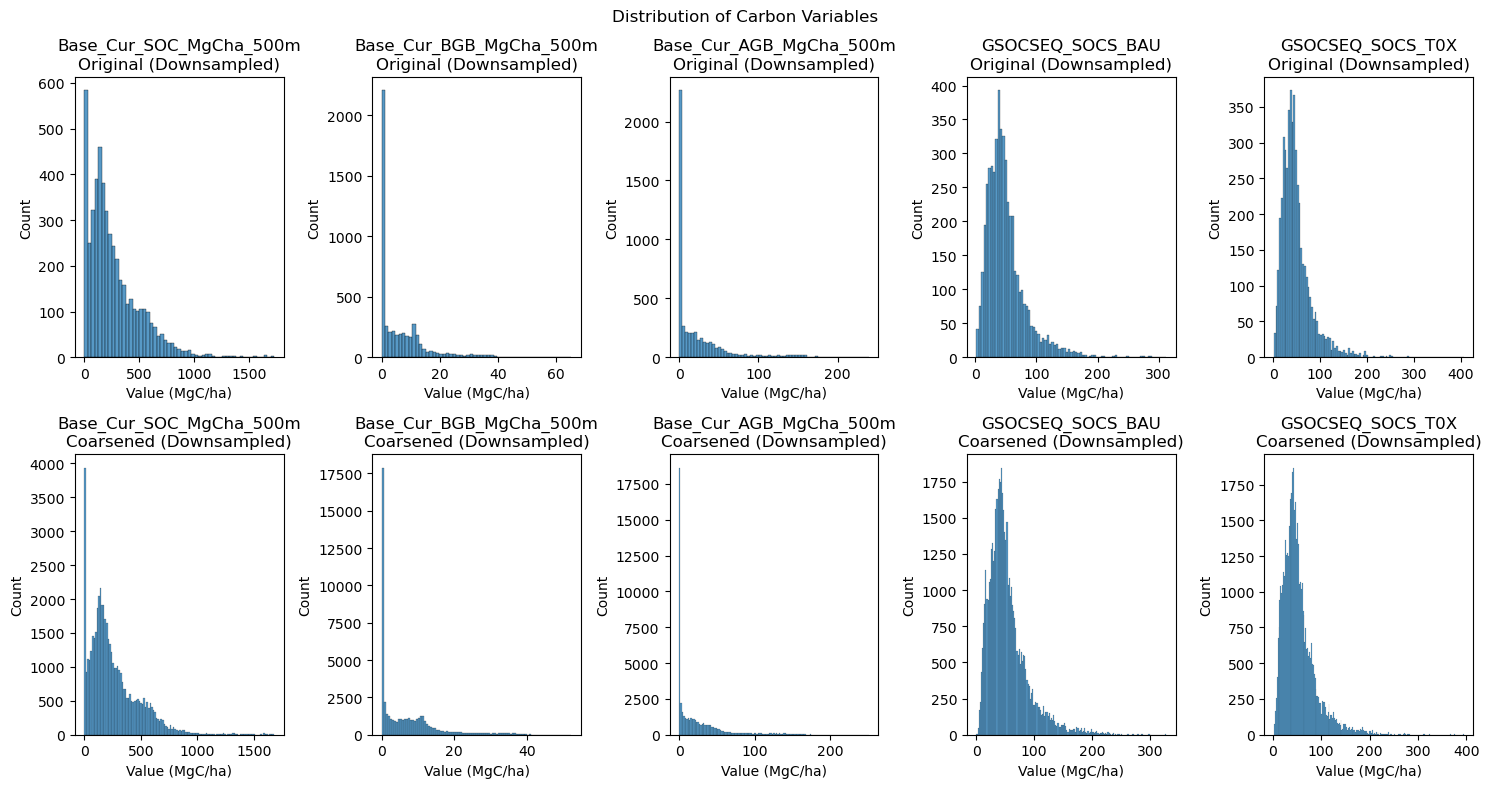

In [9]:
# Plot distribution of carbon variables with memory-efficient processing
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import dask.array as da

variables = ['Base_Cur_SOC_MgCha_500m', 'Base_Cur_BGB_MgCha_500m', 'Base_Cur_AGB_MgCha_500m', 'GSOCSEQ_SOCS_BAU', 'GSOCSEQ_SOCS_T0X']

# Create subplots for distributions
fig, axes = plt.subplots(2, len(variables), figsize=(15, 8))
fig.suptitle('Distribution of Carbon Variables')

for i, var in enumerate(variables):
    # Process data in smaller chunks with dask
    data = ds_carbon[var]
    
    # Downsample spatially first
    data = data.coarsen(lat=10, lon=10, boundary='trim').mean()
    
    # Convert to numpy array in chunks
    chunk_size = 1000  # Smaller chunk size
    sample_size = 50000  # Reduced sample size
    
    data_chunks = []
    for t in range(0, data.shape[0], chunk_size):
        chunk = data[t:t+chunk_size].values
        valid_data = chunk[~np.isnan(chunk)].flatten()
        if len(valid_data) > 0:
            # Take a small random sample from each chunk
            if len(valid_data) > sample_size//10:
                valid_data = np.random.choice(valid_data, size=sample_size//10, replace=False)
            data_chunks.append(valid_data)
        if len(np.concatenate(data_chunks)) >= sample_size:
            break
            
    if len(data_chunks) > 0:
        combined_data = np.concatenate(data_chunks)
        if len(combined_data) > sample_size:
            combined_data = np.random.choice(combined_data, size=sample_size, replace=False)
            
        # Plot original distribution
        sns.histplot(data=combined_data, ax=axes[0,i])
        axes[0,i].set_title(f'{var}\nOriginal (Downsampled)')
        axes[0,i].set_xlabel('Value (MgC/ha)')
        
        # Plot coarsened distribution
        coarse = data.coarsen(lat=10, lon=10).mean().values.flatten()
        coarse = coarse[~np.isnan(coarse)]
        if len(coarse) > sample_size:
            coarse = np.random.choice(coarse, size=sample_size, replace=False)
        
        sns.histplot(data=coarse, ax=axes[1,i])
        axes[1,i].set_title(f'{var}\nCoarsened (Downsampled)')
        axes[1,i].set_xlabel('Value (MgC/ha)')

plt.tight_layout()
plt.show()


In [16]:
from tqdm.auto import tqdm
import numpy as np
import pandas as pd




base_one_var = [
    'Base_Cur_AGB_MgCha_500m', 'Base_Cur_BGB_MgCha_500m', 'Base_Cur_SOC_MgCha_500m',
    'Base_Pot_AGB_MgCha_500m', 'Base_Pot_BGB_MgCha_500m', 'Base_Pot_SOC_MgCha_500m',
    'Base_Unr_SOC_MgCha_500m','Base_Unr_AGB_MgCha_500m', 'Base_Unr_BGB_MgCha_500m',
]
base_two_var = [
    'Base_Cur_AGB_BGB_MgCha_500m', 'Base_Pot_AGB_BGB_MgCha_500m', 'Base_Unr_AGB_BGB_MgCha_500m'
]
base_all_var = [
    'Base_Pot_AGB_BGB_SOC_MgCha_500m', 'Base_Unr_AGB_BGB_SOC_MgCha_500m', 'Base_Cur_AGB_BGB_SOC_MgCha_500m'
]
root_var = ['rmf_all_mosaic','shrub_rmf_mosaic','grass_rmf_mosaic','forest_rmf_mosaic']
rate_var = ['sequestration']
gsoil_var = ['GSOCSEQ_SOCS_BAU','GSOCSEQ_SOCS_T0X']


PERENNIAL_KEYWORDS = [
    'Alfalfa','Banana','Citrus','Cocoa','Coffee','Coconut',
    'Oil palm','Rubber','Sugarcane','Tea'
]

perennial_vars = [
    var for var in ds_carbon.data_vars
    if any(kw.lower() in var.lower() for kw in PERENNIAL_KEYWORDS)
]

print(f"自动识别多年生相关变量: {perennial_vars}")

all_vars= list(set(
    base_one_var + base_two_var + base_all_var + root_var + rate_var + gsoil_var + perennial_vars
))





def process_chunk(df_prediction, ds_merge, step,stop=0):

    # Get coordinates that exist in both df_temp and pv_df
    common_lats = np.intersect1d(ds_merge.lat.values, df_prediction['lat'].unique())
    common_lons = np.intersect1d(ds_merge.lon.values, df_prediction['lon'].unique())

    # Select data from df_temp using only the common coordinates
    ds_merge = ds_merge.sel(
        lat=common_lats,
        lon=common_lons,
    )

    #step = 500
    total_lat = len(ds_merge.lat)
    total_lon = len(ds_merge.lon)
    merged_dfs = []
    
    # Calculate total iterations for progress bar
    total_iterations = (total_lat // step + (1 if total_lat % step else 0)) * \
                    (total_lon // step + (1 if total_lon % step else 0))

    # Create progress bar with Chinese description
    pbar = tqdm(total=total_iterations, desc="处理数据块")

    # Iterate through all latitude and longitude points in chunks
    for start_lat in range(0, total_lat, step):
        end_lat = min(start_lat + step, total_lat)
        for start_lon in range(0, total_lon, step):
            end_lon = min(start_lon + step, total_lon)

            # Extract data from ds_merge for each time point
            df = ds_merge.isel(
                lat=slice(start_lat, end_lat),
                lon=slice(start_lon, end_lon)
            ).compute().to_dataframe()
            
            # Reset index to convert multi-index to columns
            df = df.reset_index()
            
            # Merge with pv_df based on lat/lon coordinates
            chunk_merged = pd.merge(df, df_prediction, on=['lat','lon','time'], how='inner')
            merged_dfs.append(chunk_merged)
            
            # Update progress bar
            pbar.update(1)
            if stop==1:
                break
    # Close progress bar
    pbar.close()
    # Combine all chunks into final dataframe
    merged_df = pd.concat(merged_dfs, ignore_index=True)
    return merged_df

def enrich_prediction_with_vars(df_prediction, ds_carbon, var_list, time_sel='2020-01-01', step=3000):
    """
    将ds_carbon中所有var_list变量在指定time_sel下批量合成进df_prediction
    返回合并后新DataFrame（行数与df_prediction一致，列包含原有+所有var_list变量）
    """
    dfs = [df_prediction]
    for var in var_list:
        print(f"Processing variable: {var}")
        # 提取单变量并与df_prediction合并
        arr = ds_carbon[var].sel(time=[time_sel]) if 'time' in ds_carbon[var].dims else ds_carbon[var]
        df_var = process_chunk(df_prediction, arr, step=step)
        # 只保留关键列防止冗余
        if var not in df_prediction.columns:
            df_var = df_var[['lat','lon','time',var]]
        dfs.append(df_var)
    # 顺次合并所有变量（按lat/lon/time合并）
    from functools import reduce
    df_all = reduce(lambda left, right: pd.merge(left, right, on=['lat','lon','time'], how='outer'), dfs)
    return df_all



# 1. 先将变量批量合成到 df_prediction_new
df_prediction['time'] = pd.to_datetime(df_prediction['time'])
df_prediction_new = enrich_prediction_with_vars(
    df_prediction,
    ds_carbon,
    all_vars,
    time_sel='2020-01-01',
    step=3000
)


# # Iterate through each variable
# # Get all variables from ds_merge



# merged_dfs = []

# df_prediction['time'] = pd.to_datetime(df_prediction['time'])

# # Iterate through each variable
# for i, var in enumerate(all_vars):
#     print(f"Processing variable {i+1} of {len(all_vars)}: {var}")
#     if var=='sequestration':
#     # Check if variable has time dimension
#         df_temp = ds_carbon[var].sel(time=['2020-01-01'])

#         # Process the chunk and merge with pv_df
#         merged_df = process_chunk(df_prediction, df_temp, step=3000)

#         merged_dfs.append(merged_df)

# Concatenate all merged dataframes with single-column retention

# final_merged_df = merged_dfs[0]
# for df in tqdm(merged_dfs[1:], desc="合并数据"):

#     final_merged_df = pd.merge(
#         final_merged_df,
#         df,
#         on=["time", "lon", "lat"],
#         how="inner",
#         suffixes=("", "_drop")
#     )
#     # Drop duplicated columns with "_drop" suffix
#     final_merged_df = final_merged_df.loc[:, ~final_merged_df.columns.str.endswith("_drop")]



自动识别多年生相关变量: ['Alfalfa_1981-2010_Historical_With CO2 Fertilization', 'Banana_1981-2010_Historical_With CO2 Fertilization', 'Citrus_1981-2010_Historical_With CO2 Fertilization', 'Cocoa_1981-2010_Historical_With CO2 Fertilization', 'Coconut_1981-2010_Historical_With CO2 Fertilization', 'Coffee_1981-2010_Historical_With CO2 Fertilization', 'Oil palm_1981-2010_Historical_With CO2 Fertilization', 'Rubber_1981-2010_Historical_With CO2 Fertilization', 'Sugarcane_1981-2010_Historical_With CO2 Fertilization', 'Tea_1981-2010_Historical_With CO2 Fertilization']
Processing variable: Sugarcane_1981-2010_Historical_With CO2 Fertilization


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: GSOCSEQ_SOCS_BAU


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: Base_Pot_BGB_MgCha_500m


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: Coconut_1981-2010_Historical_With CO2 Fertilization


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: Rubber_1981-2010_Historical_With CO2 Fertilization


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: rmf_all_mosaic


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: Base_Cur_BGB_MgCha_500m


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: Oil palm_1981-2010_Historical_With CO2 Fertilization


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: sequestration


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: forest_rmf_mosaic


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: Citrus_1981-2010_Historical_With CO2 Fertilization


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: shrub_rmf_mosaic


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: Base_Unr_SOC_MgCha_500m


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: Base_Cur_AGB_BGB_MgCha_500m


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: Base_Cur_AGB_BGB_SOC_MgCha_500m


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: grass_rmf_mosaic


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: Tea_1981-2010_Historical_With CO2 Fertilization


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: Base_Cur_AGB_MgCha_500m


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: Banana_1981-2010_Historical_With CO2 Fertilization


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: Base_Unr_AGB_MgCha_500m


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: Base_Unr_AGB_BGB_SOC_MgCha_500m


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: Cocoa_1981-2010_Historical_With CO2 Fertilization


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: Base_Unr_AGB_BGB_MgCha_500m


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: Base_Cur_SOC_MgCha_500m


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: Alfalfa_1981-2010_Historical_With CO2 Fertilization


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: Coffee_1981-2010_Historical_With CO2 Fertilization


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: Base_Pot_SOC_MgCha_500m


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: Base_Pot_AGB_BGB_MgCha_500m


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: GSOCSEQ_SOCS_T0X


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: Base_Pot_AGB_MgCha_500m


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: Base_Pot_AGB_BGB_SOC_MgCha_500m


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

Processing variable: Base_Unr_BGB_MgCha_500m


处理数据块:   0%|          | 0/3 [00:00<?, ?it/s]

## 3.5.2 三种策略期望碳汇计算

In [32]:


def fill_nonpositive_with_nearestvalue(df, target_cols=ZERO_COLS, lat_col='lat', lon_col='lon'):
    """
    使用最近邻的正值填充目标列中的值（小于等于0的值）
    
    参数:
    df: pandas DataFrame，包含经纬度和目标列
    target_cols: 需要填充的列名列表
    lat_col: 纬度列名
    lon_col: 经度列名
    
    返回:
    填充后的DataFrame
    """
    # 创建DataFrame的副本以避免修改原始数据
    df_filled = df.copy()
    
    for col in target_cols:
        if col not in df.columns:
            print(f"警告: 列 {col} 不在数据框中")
            continue
            
        # 获取正值的索引
        positive_mask = df[col] > 0
        if not positive_mask.any():
            print(f"警告: 列 {col} 中没有正值")
            continue
            
        # 构建正值点的坐标树
        positive_coords = np.column_stack([
            df.loc[positive_mask, lat_col],
            df.loc[positive_mask, lon_col]
        ])
        positive_values = df.loc[positive_mask, col].values
        tree = cKDTree(positive_coords)
        
        # 获取非正值的索引
        nonpositive_mask = (df[col] <= 0) | df[col].isna()
        if not nonpositive_mask.any():
            print(f"列 {col} 没有需要填充的非正值或NaN值")
            continue
            
        # 找到最近的正值点
        nonpositive_coords = np.column_stack([
            df.loc[nonpositive_mask, lat_col],
            df.loc[nonpositive_mask, lon_col]
        ])
        
        # 查找最近邻
        distances, indices = tree.query(nonpositive_coords, k=1)
        
        # 使用最近邻的值填充
        df_filled.loc[nonpositive_mask, col] = positive_values[indices]
        
        # print(f"列 {col} 已完成填充:")
    
    return df_filled

df_prediction_fill=fill_nonpositive_with_nearestvalue(df_prediction_new,target_cols=all_vars)

# # Plot histograms for each variable in all_vars
# import matplotlib.pyplot as plt

# fig, axes = plt.subplots(len(all_vars), 1, figsize=(10, 4*len(all_vars)))
# fig.tight_layout(pad=3.0)

# for i, var in enumerate(all_vars):
#     axes[i].hist(df_prediction_fill[var].dropna(), bins=50)
#     axes[i].set_title(f'Distribution of {var}')
#     axes[i].set_xlabel('Value')
#     axes[i].set_ylabel('Count')

# plt.show()

列 Sugarcane_1981-2010_Historical_With CO2 Fertilization 没有需要填充的非正值或NaN值
列 Coconut_1981-2010_Historical_With CO2 Fertilization 没有需要填充的非正值或NaN值
列 Rubber_1981-2010_Historical_With CO2 Fertilization 没有需要填充的非正值或NaN值
列 Oil palm_1981-2010_Historical_With CO2 Fertilization 没有需要填充的非正值或NaN值
列 Citrus_1981-2010_Historical_With CO2 Fertilization 没有需要填充的非正值或NaN值
列 Tea_1981-2010_Historical_With CO2 Fertilization 没有需要填充的非正值或NaN值
列 Banana_1981-2010_Historical_With CO2 Fertilization 没有需要填充的非正值或NaN值
列 Cocoa_1981-2010_Historical_With CO2 Fertilization 没有需要填充的非正值或NaN值
列 Alfalfa_1981-2010_Historical_With CO2 Fertilization 没有需要填充的非正值或NaN值
列 Coffee_1981-2010_Historical_With CO2 Fertilization 没有需要填充的非正值或NaN值


In [33]:
import numpy as np
import pandas as pd


YEARS = 30
DWCI_FOREST = 0.10
DWCI_AGRO = 0.02
DWCI_VEG = 0.04

PERENNIAL_KEYWORDS = [
    'Alfalfa','Banana','Citrus','Cocoa','Coffee','Coconut',
    'Oil palm','Rubber','Sugarcane','Tea'
]

def get_perennial_mask(df):
    mask = pd.Series(False, index=df.index)
    for col in df.columns:
        if any(kw in col for kw in PERENNIAL_KEYWORDS):
            mask |= df[col].isin([1, 2])
    return mask

def compute_all_strategies(df):
    df = df.copy()

    # 计算2020年基线碳储量
    agb = df['Base_Cur_AGB_MgCha_500m']
    forest_rmf_ratio = df['forest_rmf_mosaic'] * 0.01
    bgb = agb * forest_rmf_ratio / (1 - forest_rmf_ratio)
    soc = df['Base_Cur_SOC_MgCha_500m']
    
    # 森林策略基线（2020年）
    cur_forest = agb + bgb + soc + agb * DWCI_FOREST
    
    # 农业策略基线（2020年）
    per_mask = get_perennial_mask(df)
    per_rmf_ratio = df['forest_rmf_mosaic'] * 0.01
    cur_agro_bio = np.where(per_mask, 
                           agb * (1 / (1 - per_rmf_ratio) + DWCI_AGRO), 
                           0)
    cur_agro = soc + cur_agro_bio
    
    # 植被策略基线（2020年）
    shrub_rmf_ratio = df['shrub_rmf_mosaic'] * 0.01
    grass_rmf_ratio = df['grass_rmf_mosaic'] * 0.01
    
    cur_veg_bio = agb * np.where(
        df['landcover'].isin([3, 4]),
        1 / (1 - shrub_rmf_ratio) + DWCI_VEG,  # 灌木
        1 / (1 - grass_rmf_ratio) + DWCI_VEG   # 草地
    )
    cur_veg = soc + cur_veg_bio

    # 森林策略 Forest ：AGB + BGB + SOC + 增量
    # （注释部分采用现状+增量累积，现在仅计算增量）
    # 
    # df['acc_forest'] = cur_forest + df['sequestration'] * YEARS * (1 + DWCI_FOREST + df['forest_rmf_mosaic'] * 0.01) + df['Base_Unr_SOC_MgCha_500m']
    forest_multiplier = 1 / (1 - forest_rmf_ratio)
    df['acc_forest'] = (df['sequestration'] * YEARS * 
                       (forest_multiplier + DWCI_FOREST) + 
                       df['Base_Pot_SOC_MgCha_500m'])
                       
    df['cap_forest'] = df['Base_Pot_AGB_BGB_SOC_MgCha_500m'] + DWCI_FOREST * df['Base_Pot_AGB_MgCha_500m']
    df['final_forest'] = np.minimum(df['acc_forest'], df['cap_forest'])
    
    # 农业策略 Agriculture
    ratio = df['GSOCSEQ_SOCS_BAU'] / df['GSOCSEQ_SOCS_T0X']
    r_annual = ratio ** (1/20) - 1 
    r_total = (1 + r_annual) ** YEARS 
    df['acc_soc_agro'] = df['Base_Cur_SOC_MgCha_500m'] * r_total 

    df['acc_perennial'] = 0.0
    df.loc[per_mask, 'acc_perennial'] = (
        agb[per_mask] * (1 / (1 - per_rmf_ratio[per_mask]) + DWCI_AGRO)
    )

    df['acc_agro'] = df['acc_soc_agro'] + df['acc_perennial']
    cap_per = df['Base_Pot_AGB_BGB_SOC_MgCha_500m'] * (1 + DWCI_AGRO)
    df['cap_agro'] = df['Base_Pot_SOC_MgCha_500m'] + cap_per.where(per_mask, 0)
    df['final_agro'] = np.minimum(df['acc_agro'], df['cap_agro'])

    # 植被策略 Vegetation 
    df['acc_soc_veg'] = df['Base_Cur_SOC_MgCha_500m'] * r_total
    veg_multiplier = np.where(
        df['landcover'].isin([3, 4]),
        1 / (1 - shrub_rmf_ratio) + DWCI_VEG,  # 灌木
        1 / (1 - grass_rmf_ratio) + DWCI_VEG   # 草地
    )
    df['acc_bio_veg'] = df['Base_Cur_AGB_MgCha_500m'] * veg_multiplier
    
    df['acc_veg'] = df['acc_soc_veg'] + df['acc_bio_veg']
    df['cap_veg'] = df['Base_Pot_AGB_BGB_SOC_MgCha_500m']
    df['final_veg'] = np.minimum(df['acc_veg'], df['cap_veg'])

    # 计算增量碳汇 (2020-2050年期间的净增加量)
    df['baseline_forest'] = cur_forest
    df['baseline_agro'] = cur_agro  
    df['baseline_veg'] = cur_veg
    
    # 30年期间的增量碳汇
    df['increment_forest'] = df['final_forest'] - df['baseline_forest']
    df['increment_agro'] = df['final_agro'] - df['baseline_agro']
    df['increment_veg'] = df['final_veg'] - df['baseline_veg']
    
    # 保留原始增量值（包括负值）
    return df

# ------------------ 示例调用 ------------------

# 2. 计算三种策略所有像元的累计碳汇和上限，并取“双重约束”最终值
df_strategies = compute_all_strategies(df_prediction_fill)

# 3. 结果df_strategies中每行像元含：acc_forest, cap_forest, final_forest,
#    acc_agro, cap_agro, final_agro, acc_veg, cap_veg, final_veg
#    可按需做区域/策略汇总、导出等
df_strategies.to_csv('data/4.1 Restoration_strategy_data.csv', index=False)


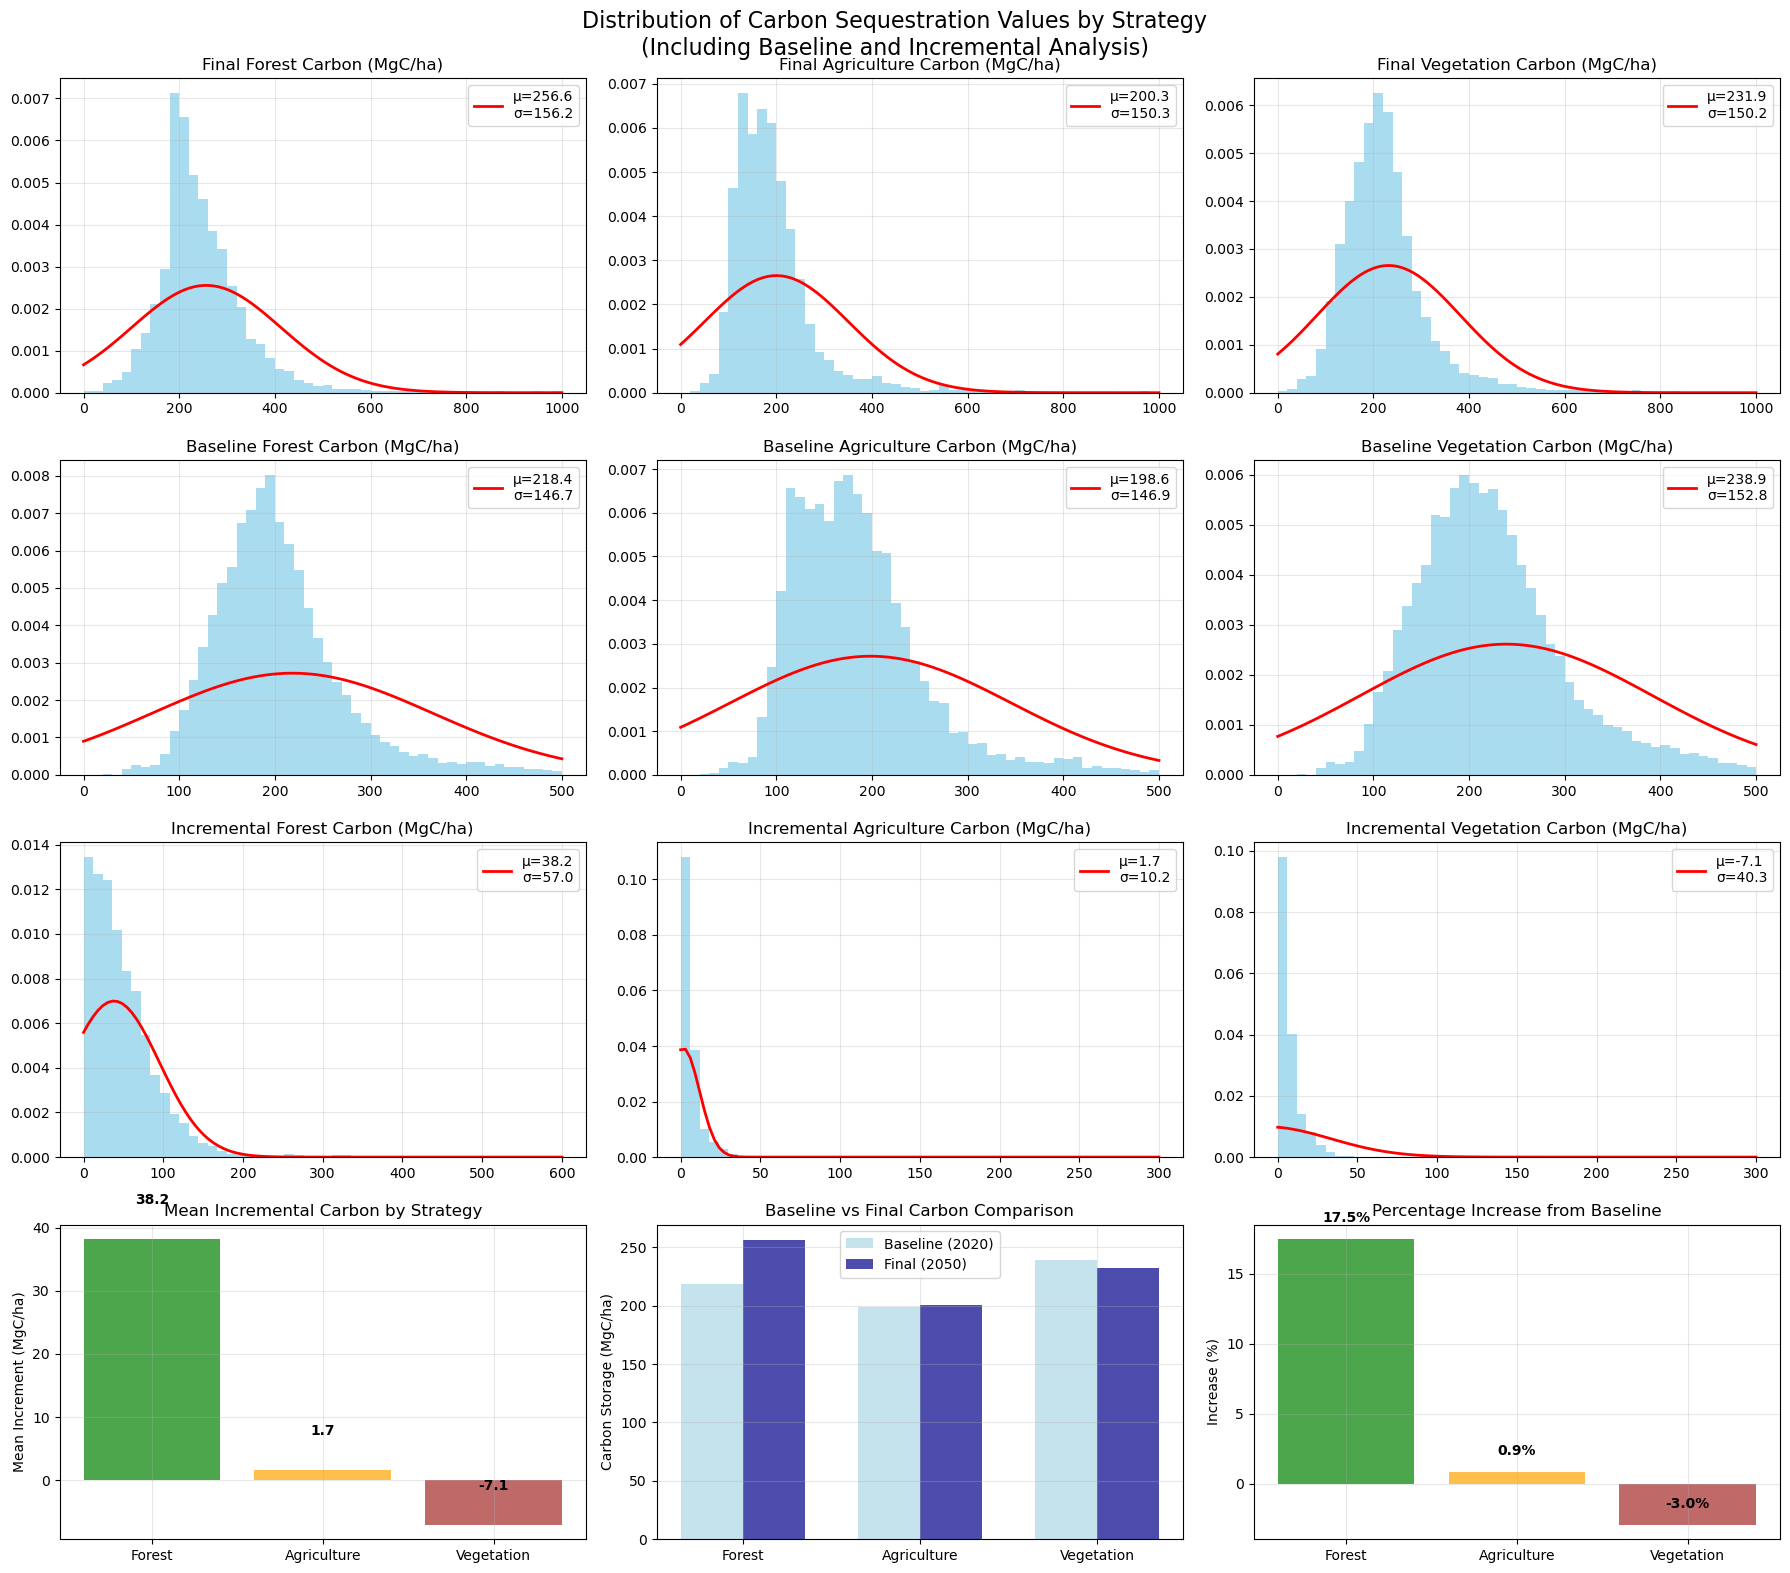


Creating spatial distribution maps for incremental carbon...


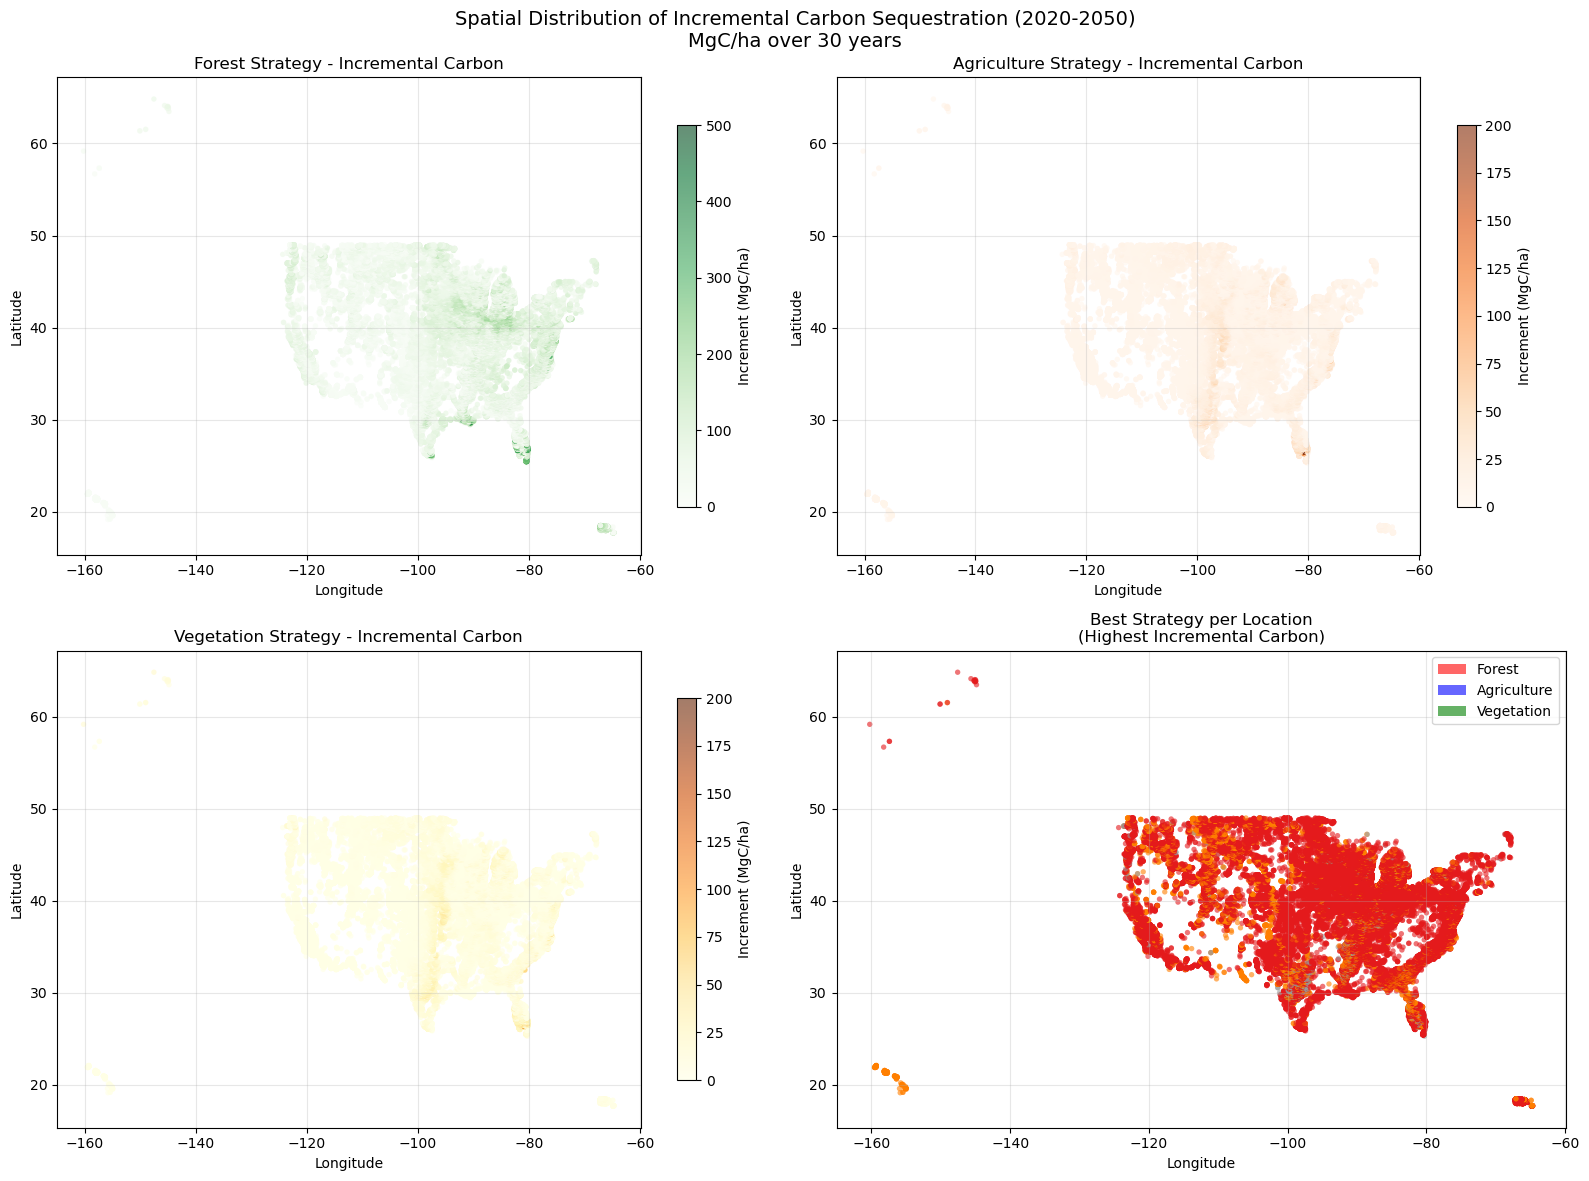


INCREMENTAL CARBON SEQUESTRATION SUMMARY (2020-2050)
      Strategy  Mean_Baseline_MgC_ha  Mean_Final_MgC_ha  \
0       Forest            218.350006             256.57   
1  Agriculture            198.589996             200.28   
2   Vegetation            238.919998             231.87   

   Mean_Increment_MgC_ha  Total_Increment_Gt  Std_Increment_MgC_ha  
0                  38.22              196.87                 57.02  
1                   1.70                8.73                 10.18  
2                  -7.05              -36.32                 40.29  

Updated DataFrame contains 71770 rows with the following key columns:
  ✓ lat
  ✓ lon
  ✓ baseline_forest
  ✓ baseline_agro
  ✓ baseline_veg
  ✓ final_forest
  ✓ final_agro
  ✓ final_veg
  ✓ increment_forest
  ✓ increment_agro
  ✓ increment_veg

Data saved to: data/4.1 Restoration_strategy_data.csv


In [34]:
# ... existing code ...

# Create enhanced histograms including baseline and increment analysis
import matplotlib.pyplot as plt
from scipy.stats import norm

fig, axes = plt.subplots(4, 3, figsize=(18, 16))
fig.suptitle('Distribution of Carbon Sequestration Values by Strategy\n(Including Baseline and Incremental Analysis)', fontsize=16)

def plot_hist_with_gaussian(data, ax, title, bins=50, range=None):
    # Filter out infinite and NaN values
    data_clean = data[np.isfinite(data)]
    if len(data_clean) == 0:
        ax.text(0.5, 0.5, 'No valid data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title)
        return
    
    if range is None:
        range = (data_clean.min(), data_clean.max())
    
    # Plot histogram
    counts, bins, _ = ax.hist(data_clean, bins=bins, range=range, density=True, alpha=0.7, color='skyblue')
    
    # Fit Gaussian
    mu, sigma = norm.fit(data_clean)
    x = np.linspace(range[0], range[1], 100)
    y = norm.pdf(x, mu, sigma)
    
    # Plot Gaussian fit
    ax.plot(x, y, 'r-', lw=2, label=f'μ={mu:.1f}\nσ={sigma:.1f}')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

# Row 1: Final carbon values (existing)
plot_hist_with_gaussian(df_strategies['final_forest'], axes[0,0], 'Final Forest Carbon (MgC/ha)', range=(0,1000))
plot_hist_with_gaussian(df_strategies['final_agro'], axes[0,1], 'Final Agriculture Carbon (MgC/ha)', range=(0,1000))
plot_hist_with_gaussian(df_strategies['final_veg'], axes[0,2], 'Final Vegetation Carbon (MgC/ha)', range=(0,1000))

# Row 2: Baseline carbon values (new)
plot_hist_with_gaussian(df_strategies['baseline_forest'], axes[1,0], 'Baseline Forest Carbon (MgC/ha)', range=(0,500))
plot_hist_with_gaussian(df_strategies['baseline_agro'], axes[1,1], 'Baseline Agriculture Carbon (MgC/ha)', range=(0,500))
plot_hist_with_gaussian(df_strategies['baseline_veg'], axes[1,2], 'Baseline Vegetation Carbon (MgC/ha)', range=(0,500))

# Row 3: Incremental carbon values (new)
plot_hist_with_gaussian(df_strategies['increment_forest'], axes[2,0], 'Incremental Forest Carbon (MgC/ha)', range=(0,600))
plot_hist_with_gaussian(df_strategies['increment_agro'], axes[2,1], 'Incremental Agriculture Carbon (MgC/ha)', range=(0,300))
plot_hist_with_gaussian(df_strategies['increment_veg'], axes[2,2], 'Incremental Vegetation Carbon (MgC/ha)', range=(0,300))

# Row 4: Comparative analysis (new)
# Comparison of incremental values across strategies
ax = axes[3,0]
strategies = ['Forest', 'Agriculture', 'Vegetation']
increments = [df_strategies['increment_forest'].mean(), 
              df_strategies['increment_agro'].mean(), 
              df_strategies['increment_veg'].mean()]
colors = ['green', 'orange', 'brown']
bars = ax.bar(strategies, increments, color=colors, alpha=0.7)
ax.set_title('Mean Incremental Carbon by Strategy')
ax.set_ylabel('Mean Increment (MgC/ha)')
ax.grid(True, alpha=0.3)
for bar, val in zip(bars, increments):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            f'{val:.1f}', ha='center', va='bottom', fontweight='bold')

# Baseline vs Final comparison
ax = axes[3,1]
baselines = [df_strategies['baseline_forest'].mean(),
             df_strategies['baseline_agro'].mean(), 
             df_strategies['baseline_veg'].mean()]
finals = [df_strategies['final_forest'].mean(),
          df_strategies['final_agro'].mean(),
          df_strategies['final_veg'].mean()]

x = np.arange(len(strategies))
width = 0.35
ax.bar(x - width/2, baselines, width, label='Baseline (2020)', color='lightblue', alpha=0.7)
ax.bar(x + width/2, finals, width, label='Final (2050)', color='darkblue', alpha=0.7)
ax.set_title('Baseline vs Final Carbon Comparison')
ax.set_ylabel('Carbon Storage (MgC/ha)')
ax.set_xticks(x)
ax.set_xticklabels(strategies)
ax.legend()
ax.grid(True, alpha=0.3)

# Percentage increase analysis
ax = axes[3,2]
pct_increases = []
for i, strategy in enumerate(['forest', 'agro', 'veg']):
    baseline_col = f'baseline_{strategy}'
    final_col = f'final_{strategy}'
    baseline_mean = df_strategies[baseline_col].mean()
    final_mean = df_strategies[final_col].mean()
    if baseline_mean > 0:
        pct_increase = ((final_mean - baseline_mean) / baseline_mean) * 100
    else:
        pct_increase = 0
    pct_increases.append(pct_increase)

bars = ax.bar(strategies, pct_increases, color=colors, alpha=0.7)
ax.set_title('Percentage Increase from Baseline')
ax.set_ylabel('Increase (%)')
ax.grid(True, alpha=0.3)
for bar, val in zip(bars, pct_increases):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Create spatial distribution maps for incremental carbon
print("\nCreating spatial distribution maps for incremental carbon...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Spatial Distribution of Incremental Carbon Sequestration (2020-2050)\nMgC/ha over 30 years', fontsize=14)

# Reset index to get lat/lon as columns
df_spatial = df_strategies.reset_index() if 'lat' in df_strategies.index.names else df_strategies

# Forest increment
scatter1 = axes[0,0].scatter(df_spatial['lon'], df_spatial['lat'], 
                            c=df_spatial['increment_forest'], cmap='Greens', 
                            s=15, alpha=0.6, edgecolors='none', vmin=0, vmax=500)
axes[0,0].set_title('Forest Strategy - Incremental Carbon')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')
cbar1 = plt.colorbar(scatter1, ax=axes[0,0], shrink=0.8)
cbar1.set_label('Increment (MgC/ha)')

# Agriculture increment
scatter2 = axes[0,1].scatter(df_spatial['lon'], df_spatial['lat'], 
                            c=df_spatial['increment_agro'], cmap='Oranges', 
                            s=15, alpha=0.6, edgecolors='none', vmin=0, vmax=200)
axes[0,1].set_title('Agriculture Strategy - Incremental Carbon')
axes[0,1].set_xlabel('Longitude')
axes[0,1].set_ylabel('Latitude')
cbar2 = plt.colorbar(scatter2, ax=axes[0,1], shrink=0.8)
cbar2.set_label('Increment (MgC/ha)')

# Vegetation increment
scatter3 = axes[1,0].scatter(df_spatial['lon'], df_spatial['lat'], 
                            c=df_spatial['increment_veg'], cmap='YlOrBr', 
                            s=15, alpha=0.6, edgecolors='none', vmin=0, vmax=200)
axes[1,0].set_title('Vegetation Strategy - Incremental Carbon')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')
cbar3 = plt.colorbar(scatter3, ax=axes[1,0], shrink=0.8)
cbar3.set_label('Increment (MgC/ha)')

# Best strategy per pixel (highest increment)
increment_cols = ['increment_forest', 'increment_agro', 'increment_veg']
best_strategy = df_strategies[increment_cols].idxmax(axis=1)
best_values = df_strategies[increment_cols].max(axis=1)

# Create color map for strategies
strategy_colors = {'increment_forest': 0, 'increment_agro': 1, 'increment_veg': 2}
strategy_color_values = [strategy_colors[s] for s in best_strategy]

scatter4 = axes[1,1].scatter(df_spatial['lon'], df_spatial['lat'], 
                            c=strategy_color_values, cmap='Set1', 
                            s=15, alpha=0.6, edgecolors='none')
axes[1,1].set_title('Best Strategy per Location\n(Highest Incremental Carbon)')
axes[1,1].set_xlabel('Longitude')
axes[1,1].set_ylabel('Latitude')

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', alpha=0.6, label='Forest'),
                  Patch(facecolor='blue', alpha=0.6, label='Agriculture'),
                  Patch(facecolor='green', alpha=0.6, label='Vegetation')]
axes[1,1].legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()

# Summary statistics table
print("\n" + "="*80)
print("INCREMENTAL CARBON SEQUESTRATION SUMMARY (2020-2050)")
print("="*80)

summary_stats = pd.DataFrame({
    'Strategy': ['Forest', 'Agriculture', 'Vegetation'],
    'Mean_Baseline_MgC_ha': [df_strategies['baseline_forest'].mean(),
                            df_strategies['baseline_agro'].mean(),
                            df_strategies['baseline_veg'].mean()],
    'Mean_Final_MgC_ha': [df_strategies['final_forest'].mean(),
                         df_strategies['final_agro'].mean(),
                         df_strategies['final_veg'].mean()],
    'Mean_Increment_MgC_ha': [df_strategies['increment_forest'].mean(),
                             df_strategies['increment_agro'].mean(),
                             df_strategies['increment_veg'].mean()],
    'Total_Increment_Gt': [df_strategies['increment_forest'].sum() * df_strategies.shape[0] / 1e9,
                          df_strategies['increment_agro'].sum() * df_strategies.shape[0] / 1e9,
                          df_strategies['increment_veg'].sum() * df_strategies.shape[0] / 1e9],
    'Std_Increment_MgC_ha': [df_strategies['increment_forest'].std(),
                            df_strategies['increment_agro'].std(),
                            df_strategies['increment_veg'].std()]
})

print(summary_stats.round(2))

# Also display the updated dataframe structure
print(f"\nUpdated DataFrame contains {len(df_strategies)} rows with the following key columns:")
key_columns = ['lat', 'lon', 'baseline_forest', 'baseline_agro', 'baseline_veg',
               'final_forest', 'final_agro', 'final_veg',
               'increment_forest', 'increment_agro', 'increment_veg']

for col in key_columns:
    if col in df_strategies.columns:
        print(f"  ✓ {col}")
    elif col in df_strategies.index.names:
        print(f"  ✓ {col} (index)")
    else:
        print(f"  ✗ {col} (missing)")

print(f"\nData saved to: data/4.1 Restoration_strategy_data.csv")

## 3.6  与光伏策略效益对比

In [35]:
# 计算不同策略概率
df_strategies['weighted_density_Forest'] = df_strategies['weighted_density_2'] + df_strategies['weighted_density_6']  # Forest
df_strategies['weighted_density_Agricultural'] = df_strategies['weighted_density_1'] + df_strategies['weighted_density_5']   # Agricultural
df_strategies['weighted_density_Vegetation'] = df_strategies['weighted_density_3'] + df_strategies['weighted_density_4'] + df_strategies['weighted_density_7'] +df_strategies['weighted_density_8'] + df_strategies['weighted_density_9']  # Othe

# 计算光伏的固碳潜力因子，这里注意0.86是当时随便加的，后面没有采用。0.27是二氧化碳转为碳的转化因子，来自文献
df_strategies['pv_potential_dens'] = df_strategies['carbon_emission (t)/yr'] * 30  * 0.27 / ( df_prediction_new['area_m2']  / 10000 ) 

df_strategies['Expectation_net_benefit'] = (df_strategies['pv_potential_dens'] 
                                          - df_strategies['final_forest'] * df_strategies['weighted_density_Forest'] 
                                          - df_strategies['final_agro'] * df_strategies['weighted_density_Agricultural'] 
                                          - df_strategies['final_veg'] * df_strategies['weighted_density_Vegetation'])
df_strategies['Revenue_ratio'] = df_strategies['pv_potential_dens'] / (df_strategies['final_forest'] * df_strategies['weighted_density_Forest'] 
                                          + df_strategies['final_agro'] * df_strategies['weighted_density_Agricultural'] 
                                          + df_strategies['final_veg'] * df_strategies['weighted_density_Vegetation'])

# Create data directory if it doesn't exist
import os
os.makedirs('data', exist_ok=True)

df_strategies[['lat','lon','time','acc_forest','cap_forest','final_forest', 'weighted_density_Forest','weighted_density_Agricultural','weighted_density_Vegetation',
               'acc_agro','cap_agro','final_agro', 
                'acc_veg' ,'cap_veg','final_veg', 'pv_potential_dens','Expectation_net_benefit','Revenue_ratio']].to_csv('data/4.df_strategies.csv',index=False)


In [36]:
min_val = (df_strategies['final_forest'] * df_strategies['weighted_density_Forest'] 
           + df_strategies['final_agro'] * df_strategies['weighted_density_Agricultural'] 
           + df_strategies['final_veg'] * df_strategies['weighted_density_Vegetation']).min()
print(min_val)

1.0619607257474675


In [37]:
df_strategies['final_forest']

0        346.100006
1        352.600006
2        354.031830
3        350.399994
4        326.600006
            ...    
71765    292.834503
71766    382.998810
71767    322.057800
71768    341.453491
71769    757.385864
Name: final_forest, Length: 71770, dtype: float32

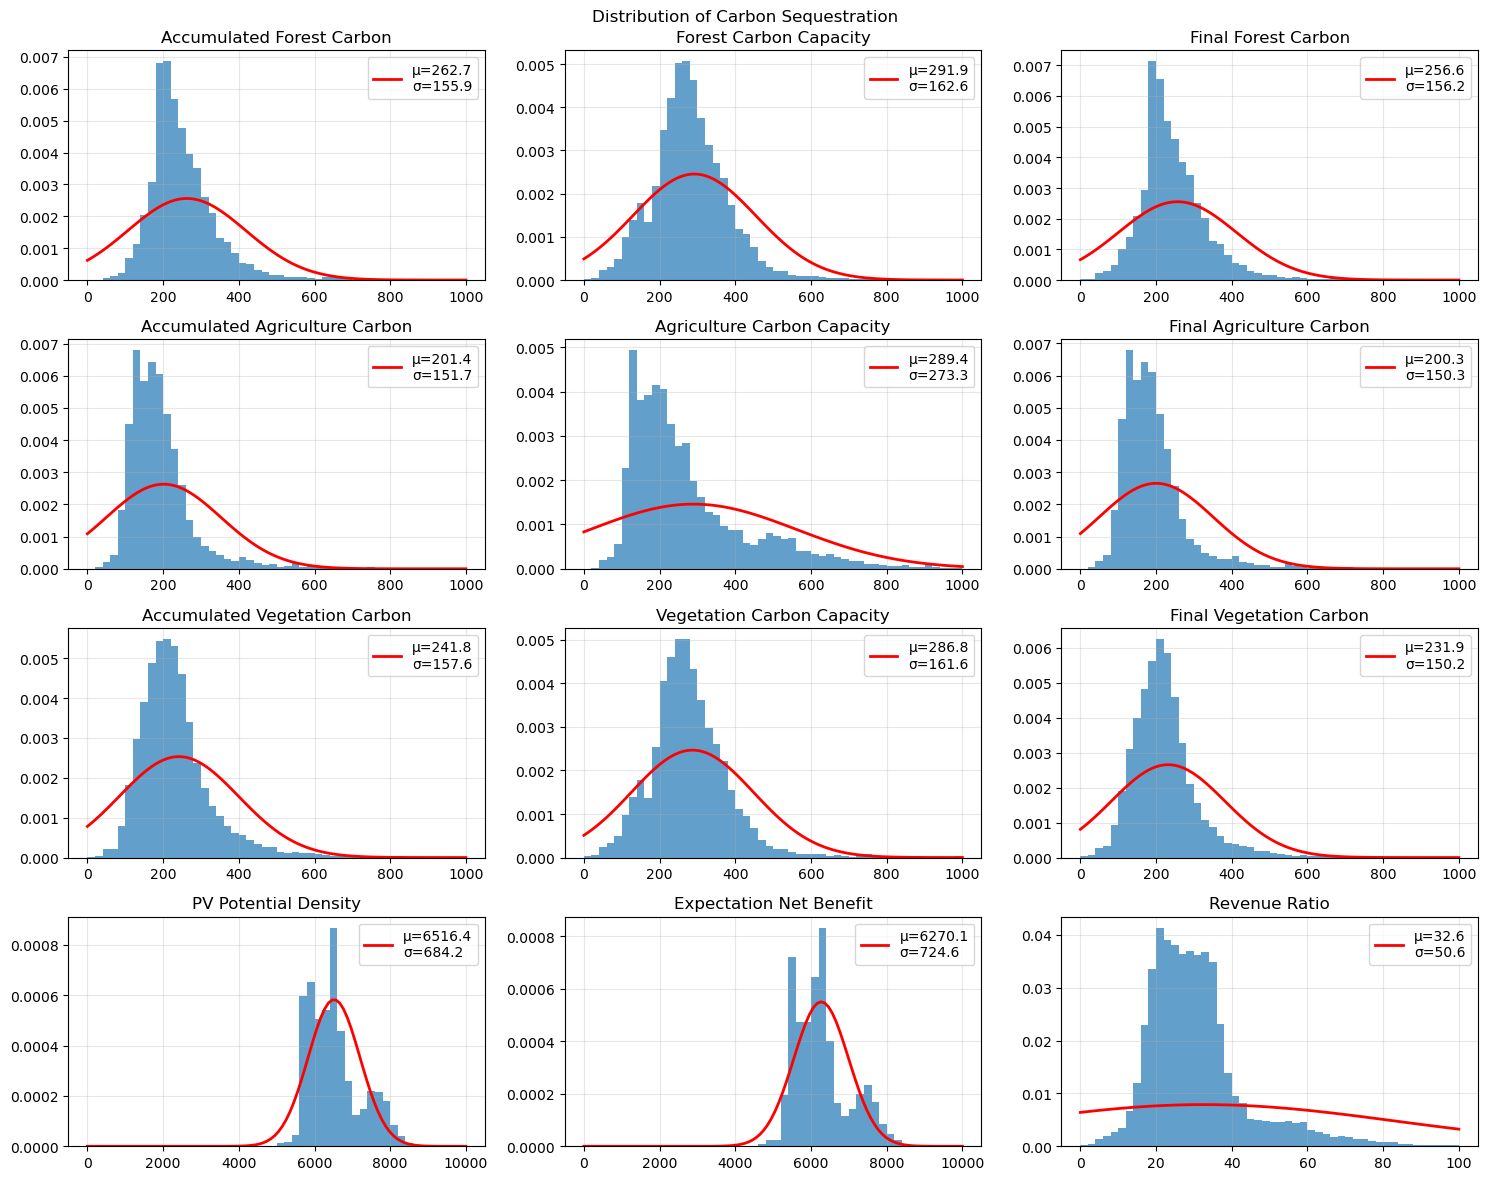

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
import matplotlib.ticker as mtick
plt.rcParams["font.family"] = "DejaVu Sans"   # 避免中文标题乱码

fig, axes = plt.subplots(4, 3, figsize=(15, 12))
fig.suptitle('Distribution of Carbon Sequestration')



def plot_hist_with_gaussian(data, ax, title, bins=50, range=(0,1000)):
    # Plot histogram
    counts, bins, _ = ax.hist(data, bins=bins, range=range, density=True, alpha=0.7)
    
    # Fit Gaussian
    mu, sigma = norm.fit(data)
    x = np.linspace(range[0], range[1], 100)
    y = norm.pdf(x, mu, sigma)
    
    # Plot Gaussian fit
    ax.plot(x, y, 'r-', lw=2, label=f'μ={mu:.1f}\nσ={sigma:.1f}')
    ax.set_title(title)
    ax.legend()

# Forest strategy distributions
plot_hist_with_gaussian(df_strategies['acc_forest'], axes[0,0], 'Accumulated Forest Carbon')
plot_hist_with_gaussian(df_strategies['cap_forest'], axes[0,1], 'Forest Carbon Capacity')
plot_hist_with_gaussian(df_strategies['final_forest'], axes[0,2], 'Final Forest Carbon')

# Agriculture strategy distributions
plot_hist_with_gaussian(df_strategies['acc_agro'], axes[1,0], 'Accumulated Agriculture Carbon')
plot_hist_with_gaussian(df_strategies['cap_agro'], axes[1,1], 'Agriculture Carbon Capacity')
plot_hist_with_gaussian(df_strategies['final_agro'], axes[1,2], 'Final Agriculture Carbon')

# Vegetation strategy distributions
plot_hist_with_gaussian(df_strategies['acc_veg'], axes[2,0], 'Accumulated Vegetation Carbon')
plot_hist_with_gaussian(df_strategies['cap_veg'], axes[2,1], 'Vegetation Carbon Capacity')
plot_hist_with_gaussian(df_strategies['final_veg'], axes[2,2], 'Final Vegetation Carbon')

# PV strategy distributions
plot_hist_with_gaussian(df_strategies['pv_potential_dens'], axes[3,0], 'PV Potential Density',range=(0,10000))
plot_hist_with_gaussian(df_strategies['Expectation_net_benefit'], axes[3,1], 'Expectation Net Benefit',range=(0,10000))
plot_hist_with_gaussian(df_strategies['Revenue_ratio'], axes[3,2], 'Revenue Ratio',range=(0,100))


plt.tight_layout()
plt.show()


## 3.7 下一步计划 


已经有一些文献对比分析了PV与森林碳汇碳NCS的潜力。需要进一步提高创新性。结合经济可行性去计算，如果可以的话，还是需要去做优化配置。